In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from scipy.special import rel_entr
import warnings
warnings.filterwarnings('ignore')

### Load Data

In [8]:
env_name = 'chicken'

env_name_list = [f'{env_name}_{_}' for _ in ['S', 'M', 'L', 'O']]
load_dir_list = [f'./data_index_33/{_}_5M_2.npz' for _ in env_name_list]
export_dir = './plots_index/'

### KL Divergence

In [9]:
for load_dir in load_dir_list:
    loaded = np.load(load_dir)
    rewards_raw = loaded['rewards']
    checkpoints = loaded['checkpoints']
    for eval_seed in [0,1,2]:
        rewards = rewards_raw[eval_seed,...] # only have 1 evaluation seed
        mean_rewards = np.mean(rewards,axis=0)
        index_list = []
        for seed in [0,1,2]:
            current_seed_list = []
            for eval_gen in range(np.shape(rewards)[0]):
                row_rewards = rewards[eval_gen,seed,:,:,0]
                col_rewards = rewards[eval_gen,seed,:,:,1]
                # start = np.min(row_rewards)
                # end = np.max(row_rewards)
                start = 0
                end = 100
                num_bins = 50
                # marginal distribution
                total_rewards = row_rewards.flatten()
                marginal_hist, marginal_bin_edges = np.histogram(total_rewards, bins=num_bins, range=(start, end))
                marginal_distribution = marginal_hist / sum(marginal_hist)
                # KL divergence
                KL_divergence = np.zeros(len(row_rewards))
                for i in range(len(row_rewards)):
                    hist, bin_edges = np.histogram(row_rewards[i], bins=num_bins, range=(start, end))
                    distribution = hist / sum(hist)
                    KL_divergence[i] = sum(rel_entr(distribution,marginal_distribution))
                # index
                index = sum(KL_divergence)/len(KL_divergence)
                index_list.append(index)
                current_seed_list.append(index)
            print(f'{load_dir}: {np.mean(current_seed_list):.3f} +/- {np.std(current_seed_list):.2f}')
    print(f'{load_dir} Avg: {np.mean(index_list):.3f} +/- {np.std(index_list):.2f}')

./data_index_33/chicken_S_5M_2.npz: 1.355 +/- 0.13
./data_index_33/chicken_S_5M_2.npz: 1.435 +/- 0.06
./data_index_33/chicken_S_5M_2.npz: 1.451 +/- 0.16
./data_index_33/chicken_S_5M_2.npz: 1.357 +/- 0.08
./data_index_33/chicken_S_5M_2.npz: 1.419 +/- 0.03
./data_index_33/chicken_S_5M_2.npz: 1.409 +/- 0.06
./data_index_33/chicken_S_5M_2.npz: 1.528 +/- 0.05
./data_index_33/chicken_S_5M_2.npz: 1.573 +/- 0.04
./data_index_33/chicken_S_5M_2.npz: 1.485 +/- 0.14
./data_index_33/chicken_S_5M_2.npz Avg: 1.529 +/- 0.09
./data_index_33/chicken_M_5M_2.npz: 1.402 +/- 0.10
./data_index_33/chicken_M_5M_2.npz: 1.484 +/- 0.15
./data_index_33/chicken_M_5M_2.npz: 1.450 +/- 0.10
./data_index_33/chicken_M_5M_2.npz: 1.430 +/- 0.07
./data_index_33/chicken_M_5M_2.npz: 1.544 +/- 0.06
./data_index_33/chicken_M_5M_2.npz: 1.431 +/- 0.06
./data_index_33/chicken_M_5M_2.npz: 1.303 +/- 0.07
./data_index_33/chicken_M_5M_2.npz: 1.496 +/- 0.05
./data_index_33/chicken_M_5M_2.npz: 1.322 +/- 0.15
./data_index_33/chicken_M_5

### Turn to DataFrame

In [62]:
# convert to dataframe for plotting
checkpoint_str = ["checkpoint "+str(x) for x in checkpoints]
# reshape the 2D Numpy array to 1D array
flattened_ego_rewards = row_rewards.flatten()
flattened_opp_rewards = col_rewards.flatten()
# Create column names for the DataFrame
column_names = ['row reward', 'col reward', 'checkpoint']
# Create an array with repeated row numbers
checkpoint_names = np.repeat(checkpoint_str, np.shape(row_rewards[:,0].flatten()))
# Create the DataFrame
df = pd.DataFrame({'row reward': flattened_ego_rewards, 'col reward': flattened_opp_rewards, 'checkpoint': checkpoint_names}, columns=column_names)
df

,row reward,col reward,checkpoint
0,7.983862,7.983862,checkpoint 0
1,5.331878,5.331878,checkpoint 0
2,9.644567,9.644567,checkpoint 0
3,9.725926,9.725926,checkpoint 0
4,8.948254,8.948254,checkpoint 0
...,...,...,...
211,19.512698,19.512698,checkpoint 24
212,17.458201,17.458201,checkpoint 24
213,22.215079,22.215079,checkpoint 24
214,18.415152,18.415152,checkpoint 24


### Ridge Plot

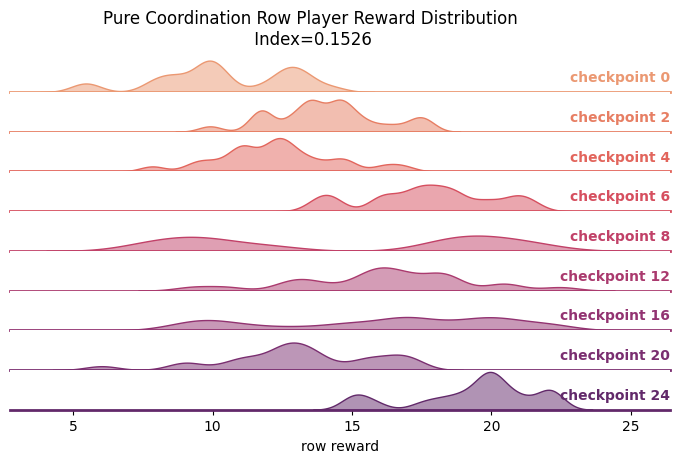

In [63]:
g = sns.FacetGrid(df, row="checkpoint", hue="checkpoint", aspect=15, height=.5, palette='flare')
# h = sns.FacetGrid(df, row="checkpoint", hue="checkpoint", aspect=15, height=.5, palette='crest')

# Draw the densities in a few steps
g.map_dataframe(sns.kdeplot, x="row reward", bw_adjust=.4, clip_on=False, fill=True, alpha=.5, linewidth=1)
# g.map_dataframe(sns.kdeplot, x="opp_reward", bw_adjust=.4, clip_on=False, fill=True, alpha=.5, linewidth=1)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(1, .2, label, fontweight="bold", color=color,
            ha="right", va="bottom", transform=ax.transAxes)

g.map(label, "row reward")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=0)

# Remove axes details that don't play well with overlap
title=env_name.replace('_',' ').title() + f' Row Player Reward Distribution\n Index={index:.4f}'
g.fig.suptitle(title, y=1.02)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# # save figure
# plt.savefig(os.path.join(export_dir, env_name.replace('_',' ')+' row reward distribution.pdf'), bbox_inches='tight')

### Comparison DataFrame

In [23]:
new_df = pd.DataFrame({'reward': df['col reward'].tolist()+df['row reward'].tolist(),
                       'label': ['col']*len(df['col reward'])+['row']*len(df['row reward']),
                       'checkpoint': df['checkpoint'].tolist()*2},
                      columns=['reward','label','checkpoint','pair'])
new_df

,reward,label,checkpoint,pair
0,12.322124,col,checkpoint 0,NaN
1,11.243915,col,checkpoint 0,NaN
2,9.934301,col,checkpoint 0,NaN
3,10.125409,col,checkpoint 0,NaN
4,10.183796,col,checkpoint 0,NaN
...,...,...,...,...
79,24.996508,row,checkpoint 24,NaN
80,22.469048,row,checkpoint 24,NaN
81,23.834127,row,checkpoint 24,NaN
82,19.550185,row,checkpoint 24,NaN


### Comparison Ridge Plot

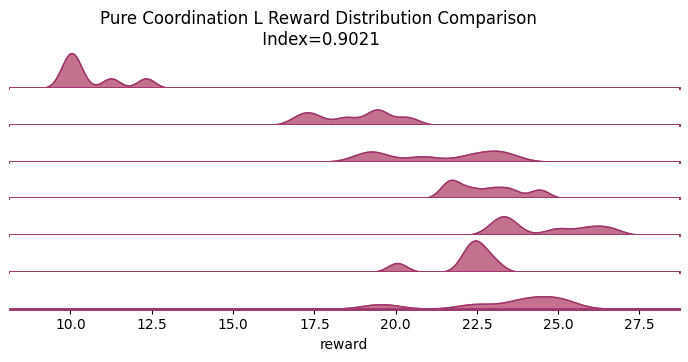

In [24]:
# g = sns.FacetGrid(new_df, row="checkpoint", hue="label", aspect=15, height=.5, palette='flare')

# # Draw the densities in a few steps
# g.map_dataframe(sns.kdeplot, x="reward", bw_adjust=.4, clip_on=False, fill=True, alpha=.5, linewidth=1)
# # g.map(sns.kdeplot, "reward", clip_on=False, color="w", lw=2, bw_adjust=.3)

# # passing color=None to refline() uses the hue mapping
# g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# # Define and use a simple function to label the plot in axes coordinates
# def label(x, color, label):
#     ax = plt.gca()
#     # ax.text(1, .2, label, fontweight="bold", color=color,
#     #         ha="right", va="bottom", transform=ax.transAxes)
# # def annotate(data, color, **kws):
# #     n = data['checkpoint']
# #     ax = plt.gca()
# #     ax.text(1, 0.2, f'{n}', fontweight="bold", color=color, ha="right", va="bottom", transform=ax.transAxes)

# g.map(label, "reward")
# # g.map_dataframe(annotate)

# # Set the subplots to overlap
# g.figure.subplots_adjust(hspace=0)

# # Remove axes details that don't play well with overlap
# title=env_name.replace('_',' ').title() + f' Reward Distribution Comparison\n Index={index:.4f}'
# g.fig.suptitle(title, y=1.02)
# g.set_titles("")
# g.set(yticks=[], ylabel="")
# g.despine(bottom=True, left=True)

# # save figure
# plt.savefig(os.path.join(export_dir, env_name.replace('_',' ')+' distribution comparison.pdf'), bbox_inches='tight')